In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

/tmp/ipykernel_104657/2501157616.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
window = 5

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path)
df

,Date,LMCADS03,LMCADY,DXY,SPX,BCOM,MXWD,XAU,XAG,LMCADY_acu_5d_log,LMCADY_std_5d_log
0,2003-01-02,0.019048,0.019834,0.010739,0.032661,0.025337,0.023209,-0.005763,0.007918,0.040542,0.007181
1,2003-01-03,0.013121,0.013478,-0.004965,-0.000484,0.014288,0.003782,0.014915,0.014833,0.015400,0.010511
2,2003-01-06,0.010804,0.010262,-0.004891,0.022226,-0.016118,0.018549,0.000000,0.001533,0.011601,0.009986
3,2003-01-07,-0.004616,-0.004479,0.005867,-0.006566,-0.002697,-0.008853,-0.011453,-0.020109,0.027062,0.009745
4,2003-01-08,0.009822,0.009771,-0.006848,-0.014186,0.004093,-0.014657,0.018206,0.010363,0.023340,0.009467
...,...,...,...,...,...,...,...,...,...,...,...
5545,2024-04-08,0.008751,0.007897,-0.001535,-0.000375,0.000216,0.001968,0.003975,0.013549,0.023212,0.010161
5546,2024-04-09,0.000637,0.000161,0.000096,0.001444,-0.001109,0.001528,0.005861,0.010767,0.007737,0.013632
5547,2024-04-10,-0.004630,-0.004594,0.010506,-0.009502,0.000649,-0.008312,-0.007997,-0.007269,0.026616,0.014112
5548,2024-04-11,-0.003420,-0.003312,0.000285,0.007417,-0.005083,0.002714,0.016352,0.017577,0.046886,0.013921


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by='Date')

df = df.reset_index(drop=True)

# Seleccionar la serie temporal de la variable de interés

targ = 'LMCADY_acu_{}d_log'.format(window)
# targ = 'LMCADY'.format(window)

time_series = df[targ]

time_series

0       0.040542
1       0.015400
2       0.011601
3       0.027062
4       0.023340
          ...   
5545    0.023212
5546    0.007737
5547    0.026616
5548    0.046886
5549    0.048523
Name: LMCADY_acu_5d_log, Length: 5550, dtype: float64

In [4]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.01, shuffle=False)

In [5]:
LMCADY_train

0       0.040542
1       0.015400
2       0.011601
3       0.027062
4       0.023340
          ...   
5489    0.021088
5490    0.023999
5491    0.023747
5492    0.003301
5493   -0.006153
Name: LMCADY_acu_5d_log, Length: 5494, dtype: float64

In [6]:
def evaluate_ar_model(train_series, test_series, lags=5):
    # asegurarse de que la serie de entrenamiento tenga un índice secuencial o temporal con frecuencia
    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()

    for actual in test_series:
        if len(current_train) <= lags:
            print(f"No hay suficientes observaciones para {lags} rezagos. Terminando el ciclo.")
            break

        model = AutoReg(current_train, lags=lags)
        model_fit = model.fit()

        prediction = model_fit.predict(start=len(current_train), end=len(current_train), dynamic=False)

        predictions.append(prediction.iloc[0])
        # print("pred {:.6f}, {:.6f}".format(prediction.iloc[0],actual))

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [7]:
def calculate_rmse(predictions, actual):
    # Asegurarse de que las series sean de igual longitud
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    # Calcular el RMSE
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [8]:
stop_lag = 100

best_predictions = None
best_lags = None
best_rmse = 999.9

for lags in range(0,stop_lag+1,1):
    LMCADY_predictions = evaluate_ar_model(LMCADY_train, LMCADY_test, lags=lags)
    LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)
    print(f"AR> El RMSE del pronóstico para {lags} lags es: {LMCADY_rmse:.6f}")

    if LMCADY_rmse < best_rmse:
        best_rmse = LMCADY_rmse
        best_lags = lags
        best_predictions = LMCADY_predictions

AR> El RMSE del pronóstico para 0 lags es: 0.027584
AR> El RMSE del pronóstico para 1 lags es: 0.014884
AR> El RMSE del pronóstico para 2 lags es: 0.014756
AR> El RMSE del pronóstico para 3 lags es: 0.014621
AR> El RMSE del pronóstico para 4 lags es: 0.014339
AR> El RMSE del pronóstico para 5 lags es: 0.013587
AR> El RMSE del pronóstico para 6 lags es: 0.013003
AR> El RMSE del pronóstico para 7 lags es: 0.013001
AR> El RMSE del pronóstico para 8 lags es: 0.012953
AR> El RMSE del pronóstico para 9 lags es: 0.013030
AR> El RMSE del pronóstico para 10 lags es: 0.012984
AR> El RMSE del pronóstico para 11 lags es: 0.012224
AR> El RMSE del pronóstico para 12 lags es: 0.012236
AR> El RMSE del pronóstico para 13 lags es: 0.012384
AR> El RMSE del pronóstico para 14 lags es: 0.012392
AR> El RMSE del pronóstico para 15 lags es: 0.012414
AR> El RMSE del pronóstico para 16 lags es: 0.011759
AR> El RMSE del pronóstico para 17 lags es: 0.011776
AR> El RMSE del pronóstico para 18 lags es: 0.011733
AR>

In [9]:
print("El mejor rendimiento fue de {} lags con un rmse de {:.6f}".format(best_lags,best_rmse))

El mejor rendimiento fue de 50 lags con un rmse de 0.011202


In [10]:
LMCADY_test.describe()

count    56.000000
mean      0.010805
std       0.026234
min      -0.041250
25%      -0.008549
50%       0.009104
75%       0.032561
max       0.057085
Name: LMCADY_acu_5d_log, dtype: float64

In [11]:
def plot_predictions(test_series, predictions, title):
    plt.figure(figsize=(12, 6))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-')
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--')

    plt.title(f"AR Model: {title}")
    plt.legend()
    plt.show()

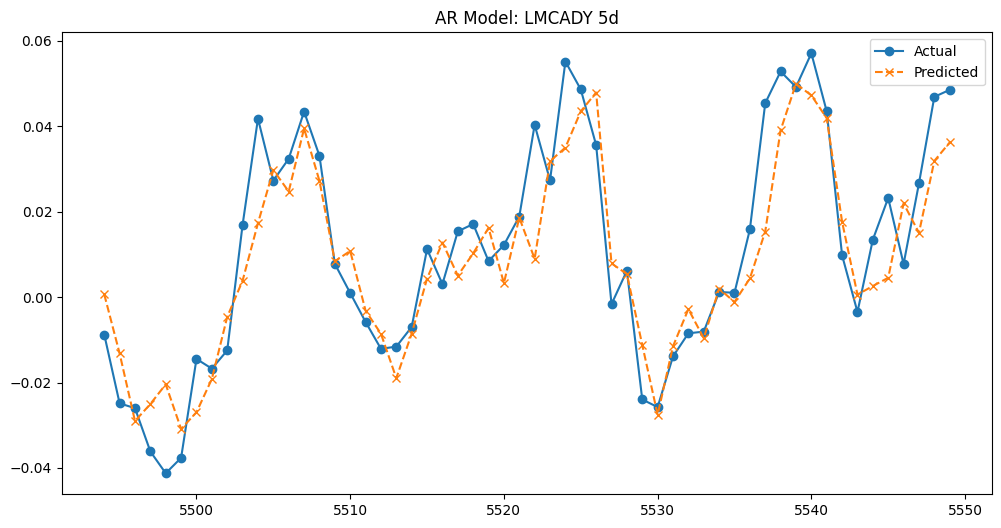

In [12]:
plot_predictions(LMCADY_test, best_predictions, "LMCADY {}d".format(window))

In [13]:
# df['LMCADY_acu_{}d_log'.format(window)].describe()
# df['LMCADY'.format(window)].describe()
